In [56]:
import os
import pathlib

if pathlib.Path(os.curdir).resolve().name != "DeepAWB":
    os.chdir("..")

In [57]:
import importlib

import src.deep_awb.data_loaders as data_loaders

importlib.reload(data_loaders)

image_scale = 1.5
data_loaders.SimpleCubePPDatasetInfo.setup(image_scale)

dataset = data_loaders.get_test_dataset()

In [58]:
import torch

import src.deep_awb.model_inference as model_inference

model = model_inference.load_model(pathlib.Path("./traced_model.pt"))


model = model_inference.optimize_model(model, torch.randn(1, 3, *data_loaders.SimpleCubePPDatasetInfo.image_dims))

2024-09-15 00:43:07.538 | INFO     | src.deep_awb.model_inference:load_model:81 - Current device: cpu


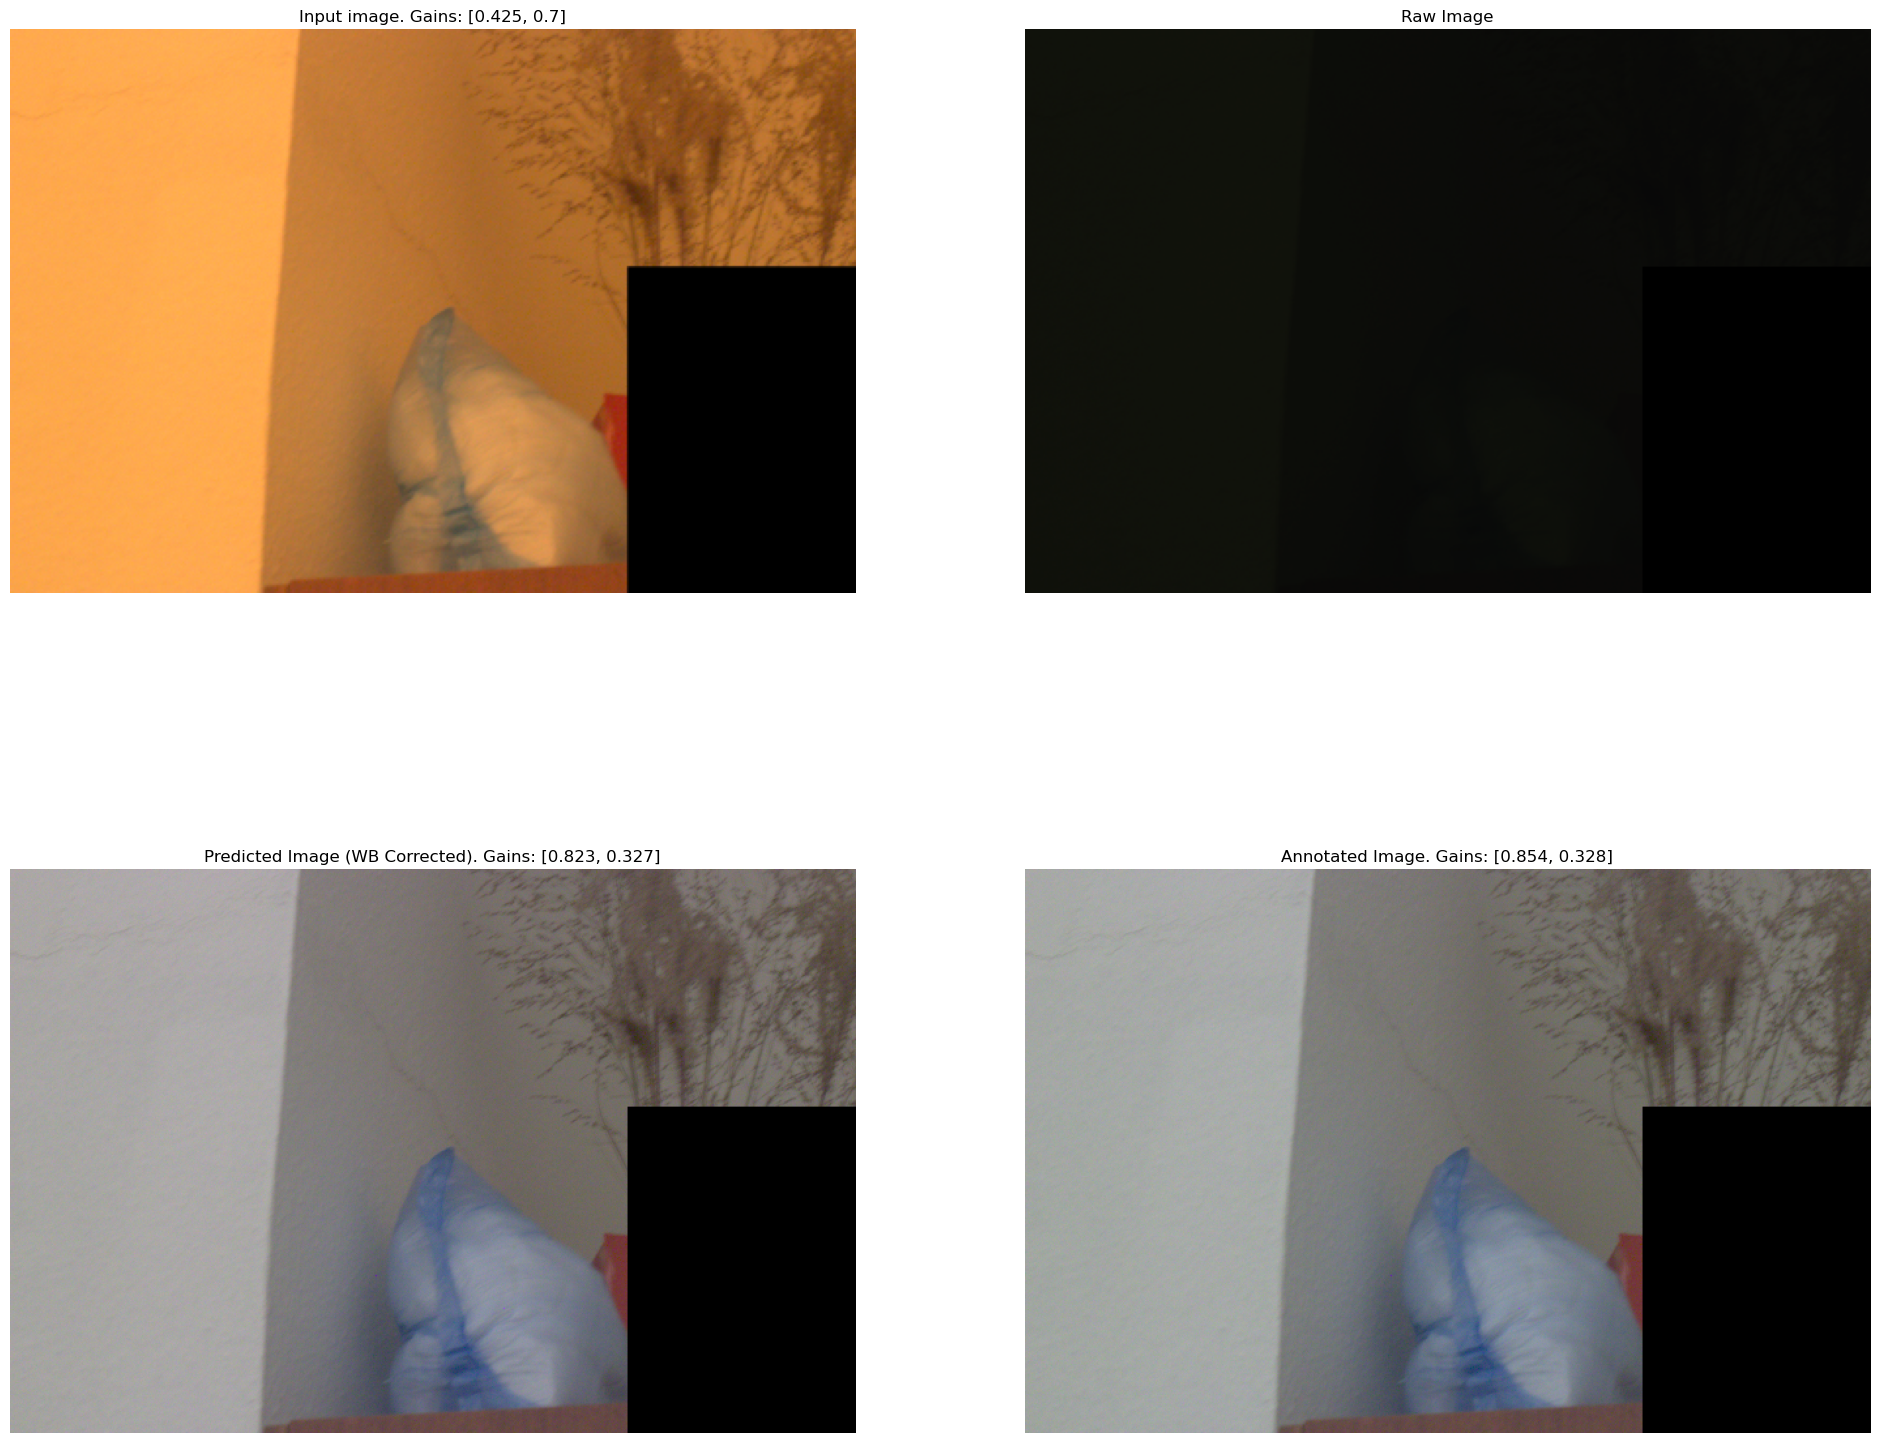

In [66]:
import random

import matplotlib.pyplot as plt
from PIL import Image

from src import DATASET_DIR
from torchvision.transforms.functional import to_pil_image
from src.visualization.image_visualization import image_processing_pipeline

N_images = len(dataset)

i = random.randint(0, N_images - 1)

processable_image, label = dataset[i]
wb_gains = model(processable_image.unsqueeze(0))

image_name = dataset.annotations["image"][i] + ".png"
input_image = to_pil_image(processable_image)

raw_image_path = DATASET_DIR / "test" / "PNG" / image_name
raw_image = Image.open(raw_image_path)

predicted_image = image_processing_pipeline(raw_image_path, None, wb_gains.numpy()[0])
predicted_image = Image.fromarray(predicted_image)

annotated_image = image_processing_pipeline(raw_image_path, None, label.numpy())
annotated_image = Image.fromarray(annotated_image)


n_decimals = 3
predicted_gains_rounded = [round(gain, n_decimals) for gain in wb_gains.numpy()[0]]
annotated_gains_rounded = [round(gain, n_decimals) for gain in label.numpy()]

images_to_display = [(f"Input image. Gains: {[0.425, 0.7]}", input_image), ("Raw Image", raw_image), (f"Predicted Image (WB Corrected). Gains: {predicted_gains_rounded}", predicted_image), (f"Annotated Image. Gains: {annotated_gains_rounded}", annotated_image)]
assert len(images_to_display) == 4

fig, ax = plt.subplots(2, 2, figsize=(24, 20))
for i in range(4):
    row, column = divmod(i, 2)
    square = ax[row][column]

    square.imshow(images_to_display[i][1])
    square.set_title(images_to_display[i][0])
    square.axis("off")

plt.show()